In [144]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time
#import pandoc

# Investigating effct of CRN structure on NOx emission using Cantera

## Introduction
Low-order models can be used for investigating NO$_x$ emission from combustion processes. The complex flame dynamics are usually reduced to a system of 0D or 1D chemical reaction systems, in the best case comprising all crucial aspects to replicate real world processes with satisfactory accuracy. These systems can be implemented and solved with Cantera Software, providing pre-configured tools for low-order combustion modelling such as the 0D PSR (perfectly stirred reactor) or 1D FreeFlame.

As generally known, combustion characteristics such as NO$_x$ formation can be very sensitive to small changes in operation conditions and flame dynimcs, such as residence time, inlet temperature, and species composition in the flame. However, the 0D and 1D model ideally should result in equal, or at least very similar, results in terms of NO$_x$ formation, when simulated with identical model inputs. 

As shown below, performing a simulation with a 0D reactor network and 1D FreeFlame using identical operation conditions can result in highly divergent outputs, with matching results only for special cases. However, this difference can be resolved by optimizing the CRN model structure.

## Preparing gas object
A routine is used to create a gas object at inlet conditions:

In [145]:
def initialize(gas,T,P,Phi,fuel,ox):
    gas.TP  = T,P
    gas.set_equivalence_ratio(Phi, fuel, ox)
    return gas

The gas object can be initialized with:

In [146]:
mech  = 'gri30.yaml'      #defining reaction mechanism
gas   = ct.Solution(mech) #creating gas object
T_in  = 450+273.15        #[K]
p_in  = ct.one_atm        #[Pa]
Phi   = 0.8               #equivalence ratio [-]
x_NH3 = 0                 #mol-fraction of ammonia [ppm]
fuel_molar_dry = {'H2':0, 'CH4' : 1, 'NH3':x_NH3/1e6} #vol-fraction of fuel
oxidizer       = {'O2':1,'N2':3.76}                   #vol-fraction of oxidizer (air)


gas  = initialize(gas,T_in,p_in,Phi,fuel_molar_dry,oxidizer)

#print inlet condition as example
print('Gas temperature: %.2f K ;  CH4 mol-frac: %.2f ;  O2 mol-frac: %.2f' % (gas.T, gas['CH4'].X[0], gas['O2'].X[0]))

Gas temperature: 723.15 K ;  CH4 mol-frac: 0.08 ;  O2 mol-frac: 0.19


## Base Case - Cantera 1D FreeFlame
Cantera's 1D FreeFlame resolves flame properties for a steady-state flat flame on a 1D grid. This provides information not only for the fully combusted state, but provides a patial evolution of combustion characteristics throughout the flame also considering diffusion effects.

A standard version of such a FreeFlame from Cantera website is used and adapted. The FreeFlame consists of 3 section: defining model input, solving FreeFlame, and extracting data.

In [147]:
def FreeFlame(gas):
    #%% defining model
    f = ct.FreeFlame(gas, width=0.04)
    refine_criteria = {"ratio": 3, "slope": 0.1, "curve": 0.2}
    f.set_refine_criteria(**refine_criteria)
    f.transport_model = None   #'Multi'

    #%% solving flame
    f.solve(loglevel=0,refine_grid=True, auto=True)

    #%% extracting flame properties
    z   = f.flame.grid
    T   = f.T
    u   = f.velocity

    #defining progress variable
    c_progress = (T-T[0])/(max(T)-T[0]) # progress variable
    c_flameFrontStart = 0.01
    c_flameFrontEnd   = 0.99
    
    #computing flame residence time 
    residenceTime_FreeFlame = np.trapz(1/u[np.argmax(c_progress>c_flameFrontStart)-1:np.argmax(c_progress>c_flameFrontEnd)], z[np.argmax(c_progress>c_flameFrontStart)-1:np.argmax(c_progress>c_flameFrontEnd)]) *1000 ; #[ms]

    flame_front_end         = z[np.argmax(c_progress>c_flameFrontEnd)]
    flame_front_start       = z[np.argmax(c_progress>c_flameFrontStart)-1]
    pos_flame_front_start   = np.argmax(c_progress>c_flameFrontStart)-1
    pos_flame_front_end     = np.argmax(c_progress>c_flameFrontEnd)
    return f,residenceTime_FreeFlame,pos_flame_front_start,pos_flame_front_end

Calling the FreeFlame for above defined inlet conditions:

In [148]:
gas = initialize(gas,T_in,p_in,Phi,fuel_molar_dry,oxidizer)  #initializing gas object
t = time.time() 
f,residenceTime_FreeFlame,pos_flame_front_start,pos_flame_front_end = FreeFlame(gas)                   #running FreeFlame simulation

print('FreeFlame solved in %.2fs' % (time.time()-t))
print('FreeFlame T_out: %.0fK' % (f.T[-1]))

FreeFlame solved in 5.67s
FreeFlame T_out: 2281K


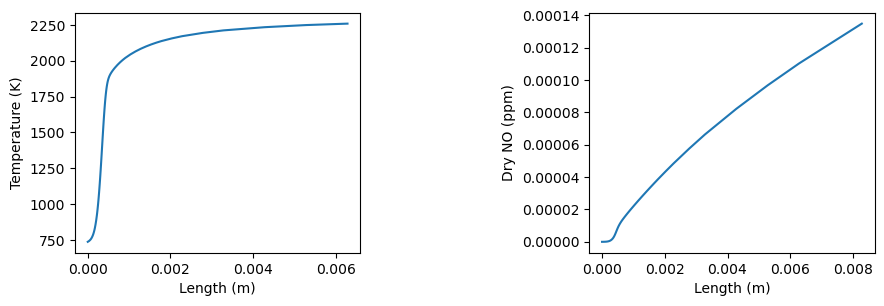

In [157]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(f.grid[pos_flame_front_start:pos_flame_front_end]-f.grid[pos_flame_front_start], f.T[pos_flame_front_start:pos_flame_front_end])
plt.xlabel('Length (m)')
plt.ylabel('Temperature (K)')

plt.subplot(1, 2, 2)
parameter = 'NO'
plt.plot(f.grid[pos_flame_front_start:pos_flame_front_end+1]-f.grid[pos_flame_front_start], f.X[gas.species_index('NO'),pos_flame_front_start:pos_flame_front_end+1]/(1-f.X[gas.species_index('H2O'),pos_flame_front_start:pos_flame_front_end+1]))
plt.xlabel('Length (m)')
plt.ylabel('Dry NO (ppm)')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)
plt.show()

## Structure of CRN
The results from the FreeFlame base case from above are compared to the output of a CRN consisting of 1 or multiple PSR. The CRN will use equal operation conditions as the base case. Additionally, the volume of the CRN will be adjusted such that the residence time is similar to the base case. 

The CRN will be structured as a chain of N PSRs - N PSRs are connected in series. The total volume V$_{tot}$ of the CRN is constant. Each PSR in the CRN has a volume of 
$\begin{align}
V_{PSR_i} = \frac{V_{tot}}{N}
\end{align}$

The CRN consists of a reservoir at inlet conditions. The reservoir is linked to the first PSR via a massflow controller. All subsequent PSRs are connected via pressure controllers, using the massflow controller as primary. The last PSR discharges into a reservoir at ambient conditions.



## Defining CRN
The reactor network will be defined in the following routine. Input variables are the gas object set to inlet conditions, residence time of the FreeFlame, as well as the number of PSR reactors in the chain.

In [150]:
def reactor_net(gas,residenceTime_flame,numReactors):
    massFlow_premix = 1 #arbitrary mass flow [kg/s]
    ReservoirPremix = ct.Reservoir(gas, name='ResPremix') #defining inlet reservoir with gas at inlet conditions
    
    gas.equilibrate('HP') #equilibrate gas at inlet conditions 
    
    r                = [ct.Reactor(gas, name=f'reactor_{i}') for i in range(numReactors)] #creating N reactors
    reactor_volume   = massFlow_premix*residenceTime_flame/1000/gas.density *1 #setting total reactor volume V_tot [m3]
    for r_i in r:
        r_i.volume = reactor_volume/numReactors  #setting reactor volume of individual PSRs V_PSR = V_tot/N

    ReservoirOutlet  = ct.Reservoir(gas, name='ResOutlet') #defining outlet reservoir ambient
    
    mc_Res2Reactor    = ct.MassFlowController(ReservoirPremix, r[0], mdot=massFlow_premix)  #defining mass flow controller from inlet reservoir to first reactor
    pc_ReactorChain   = [ct.PressureController(r[i], r[i+1], primary=mc_Res2Reactor, K=1e-5) for i in range(numReactors-1)] #pressure controllers connecting PSR with subsequent PSR at minimal pressure loss K
    pc_reactor2Outlet = ct.PressureController(r[-1],ReservoirOutlet, primary=mc_Res2Reactor, K=1e-5) #pressure controller linking last PSR with outlet reservoir
    
    reactors     = [*r] #adding all PSR reactors to one list
    sim = ct.ReactorNet(reactors) #creating CRN
    sim.reinitialize() 
    sim.initial_time =0.0    # reset the integrator
    #sim.max_time_step = 1e-6 
    sim.advance_to_steady_state() #solving CRN
    
    reactor_mass = np.sum([r_i.mass for r_i in r])  #computing total mass
    residenceTime_Flame = reactor_mass/massFlow_premix*1000 #computing total residence time

    return reactors, residenceTime_Flame

## Running CRN as function of N (number of PSR in CRN)

In [151]:
reactor_all = []
for num_reactors in [1,5,10,12]: #[1,2,5,10,20,21,22,23]
    t=time.time()
    gas = initialize(gas,T_in,p_in,Phi,fuel_molar_dry,oxidizer)
    reactors, residenceTime_Flame = reactor_net(gas,residenceTime_FreeFlame,num_reactors)
    reactor_all.append(reactors)
    print('sim done in %.2fs: %.2f reactors , resTime CRN: %.2fms , resTime FreeFlame: %.2fms'%(time.time()-t,num_reactors,residenceTime_Flame,residenceTime_FreeFlame))


sim done in 0.06s: 1.00 reactors , resTime CRN: 1.40ms , resTime FreeFlame: 1.34ms
sim done in 1.13s: 5.00 reactors , resTime CRN: 1.39ms , resTime FreeFlame: 1.34ms
sim done in 4.58s: 10.00 reactors , resTime CRN: 1.38ms , resTime FreeFlame: 1.34ms
sim done in 7.13s: 12.00 reactors , resTime CRN: 1.38ms , resTime FreeFlame: 1.34ms


With the following routine, data for plotting is extracted from the CRN simulation results.

In [152]:
def reactor_results(reactor,parameter,gas):
    gas = initialize(gas,T_in,p_in,Phi,fuel_molar_dry,oxidizer)
    initial_H2O  = gas['H2O'].X[0]
    if parameter=='T':
        initial_T    = gas.T
    else:
        initial_para = gas[parameter].X[0]
    
    if parameter=='T':
        out   = [r.T for r in reactor]
        out.insert(0,initial_T)
    elif parameter=='NO':
        H2O = [r.thermo['H2O'].X[0] for r in reactor]
        H2O.insert(0,initial_H2O)
        out = [r.thermo['NO'].X[0] for r in reactor]
        out.insert(0,initial_para)
        out = np.array(out)/(1-np.array(H2O))*1e6
    else:
        out = [r.thermo[parameter].X[0] for r in reactor]
        out.insert(0,initial_para)
    
    # t = np.linspace(0,flameTime[pos_flame_front_end]-flameTime[pos_flame_front_start],num_reactors+1)
    num_r = np.size(out)
    x = np.linspace(0,f.grid[pos_flame_front_end]-f.grid[pos_flame_front_start],num_r)
    return x,out

## Ploting results

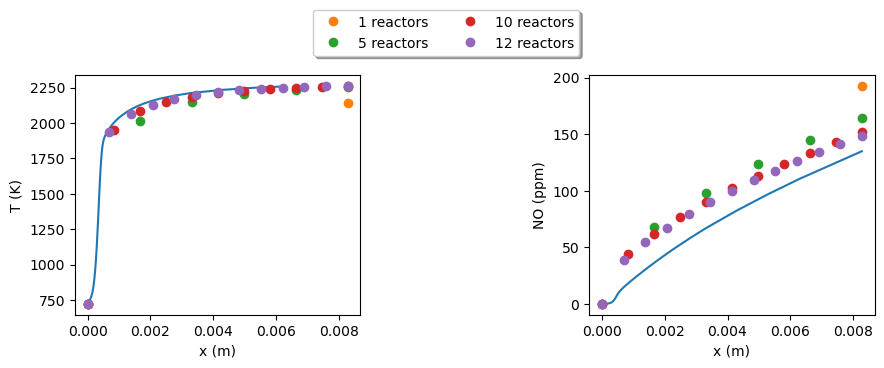

In [155]:
fig = plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(f.grid[pos_flame_front_start:pos_flame_front_end]-f.grid[pos_flame_front_start], f.T[pos_flame_front_start:pos_flame_front_end])
parameter = 'T'
unit = ' (K)'
for reactors in reactor_all:
    x,out = reactor_results(reactors,parameter,gas)
    plt.plot(x,out,'o',label=str(np.size(reactors))+" reactors")
plt.ylabel(parameter+unit)
plt.xlabel('x (m)')


ax = plt.subplot(1, 2, 2)
# plt.plot(flameTime[pos_flame_front_start:pos_flame_front_end]-flameTime[pos_flame_front_start], f.X[gas.species_index('NO'),pos_flame_front_start:pos_flame_front_end]/(1-f.X[gas.species_index('H2O'),pos_flame_front_start:pos_flame_front_end]))
# plt.plot(t,reactor_NO,'ro')
plt.plot(f.grid[pos_flame_front_start:pos_flame_front_end+1]-f.grid[pos_flame_front_start], f.X[gas.species_index('NO'),pos_flame_front_start:pos_flame_front_end+1]/(1-f.X[gas.species_index('H2O'),pos_flame_front_start:pos_flame_front_end+1])*1e6)
parameter = 'NO'
unit = ' (ppm)'
for reactors in reactor_all:
    x,out = reactor_results(reactors,parameter,gas)
    plt.plot(x,out,'o',label=str(np.size(reactors))+" reactors")
plt.ylabel(parameter+unit)
plt.xlabel('x (m)')
plt.legend()

ax.legend(loc='upper center', bbox_to_anchor=(-0.5, 1.3),
          ncol=2, fancybox=True, shadow=True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.4)
plt.show()

## Conclusion

#### watermark

In [170]:
%load_ext watermark
%watermark -v -m -p cantera,numpy,matplotlib
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

cantera   : 3.0.0
numpy     : 1.26.0
matplotlib: 3.8.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Last updated: Fri Apr 12 2024 10:11:21Mitteleuropäische Sommerzeit

